In [257]:
import pandas as pd
import numpy as np

import os

import time

from brendapy import BrendaParser
from brendapy.console import console

from tqdm import tqdm

import glob

import json

import requests

import missingno as msno

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools
from rdkit import RDConfig

from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqIO.FastaIO import FastaWriter

from sgt import SGT

import pandarallel

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

from allennlp.commands.elmo import ElmoEmbedder
from pathlib import Path

from surprise import Reader

import collections

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

# Exploring Size and Shape of BRENDA Data

In [2]:
input_df = pd.read_csv('all_data_combined_clean.tsv', sep='\t')

In [3]:
print(f"there are {input_df['uniprot_ids'].nunique()} unique proteins and {input_df['CID'].nunique()} unique compounds")

there are 4235 unique proteins and 717 unique compounds


In [4]:
sub_df = input_df[['uniprot_ids','CID']]
sub_df['value'] = 1

<ipython-input-4-4c23df4cc242>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['value'] = 1


In [5]:
pivot_df_m_n = pd.pivot_table(sub_df, values='value', index='CID', columns='uniprot_ids', aggfunc='sum')

In [6]:
pivot_df_m_n.shape

(717, 4235)

In [7]:
pivot_df_n_m = pd.pivot_table(sub_df, values='value', index='uniprot_ids', columns='CID', aggfunc='sum')

## Sparsity

<AxesSubplot:>

<Figure size 1800x720 with 2 Axes>

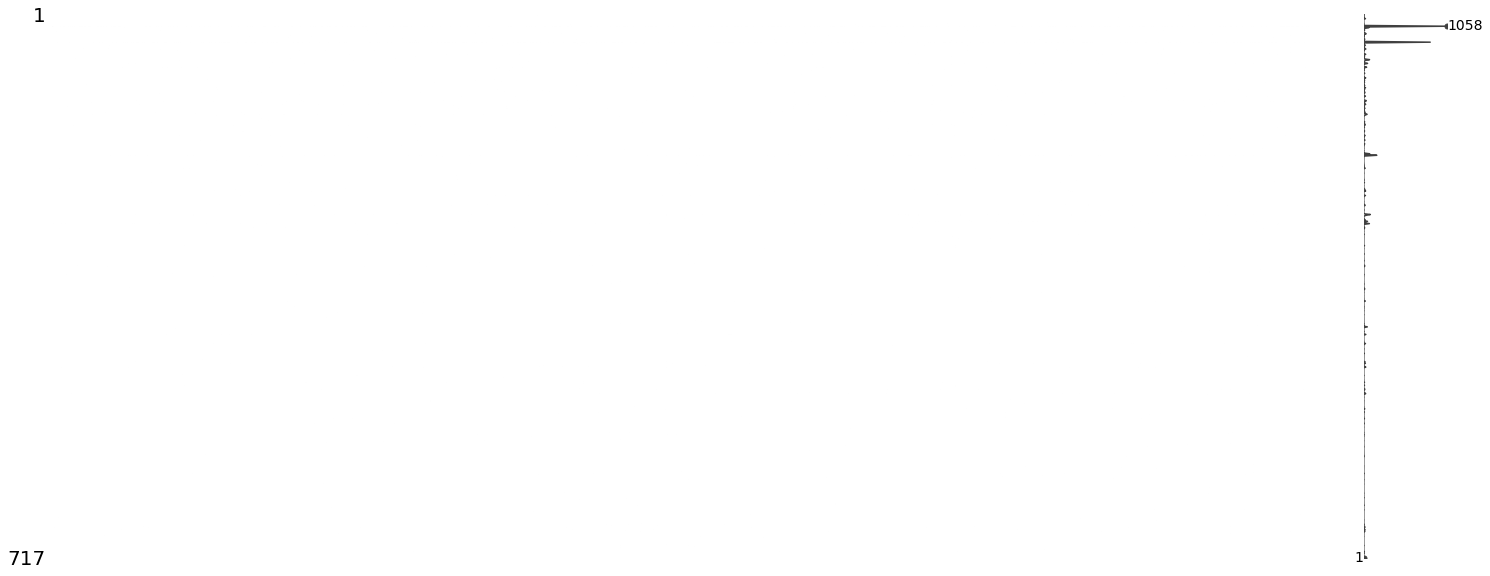

In [159]:
msno.matrix(pivot_df_m_n)

<AxesSubplot:>

<Figure size 1800x720 with 2 Axes>

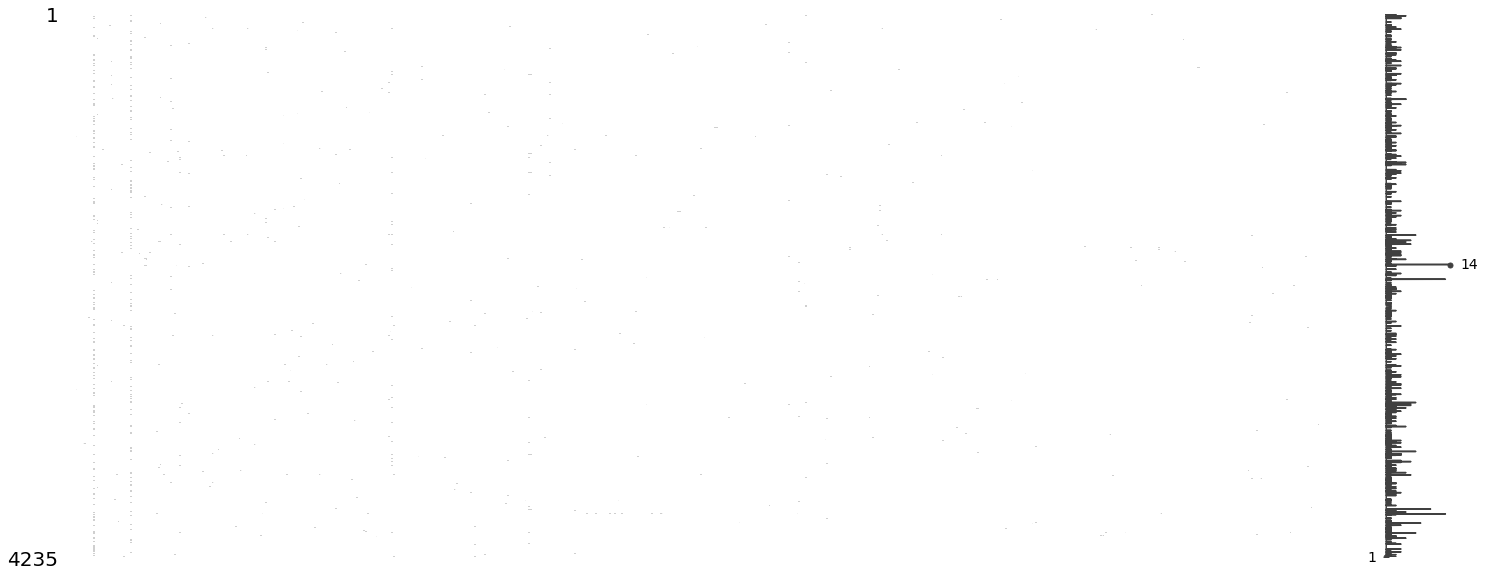

In [160]:
msno.matrix(pivot_df_n_m)

<AxesSubplot:>

<Figure size 432x288 with 1 Axes>

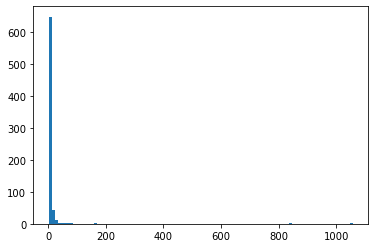

In [161]:
sub_df.groupby('CID').sum()['value'].hist(grid=False, bins=100)

<AxesSubplot:>

<Figure size 432x288 with 1 Axes>

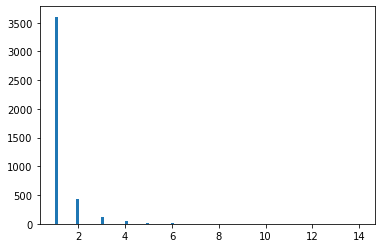

In [162]:
sub_df.groupby('uniprot_ids').sum()['value'].hist(grid=False, bins=100)

## Let's try Pfams as an abstraction here

In [8]:
input_df_pfam = input_df[['pfam_ids','CID']]
input_df_pfam = input_df_pfam[pd.notna(input_df_pfam['pfam_ids'])]

In [9]:
pfam_ids_unroll = []
cids = []

for idx,row in input_df_pfam.iterrows():
    cid = row['CID']
    
    for pfam in row['pfam_ids'].split(';'):
        pfam_ids_unroll.append(pfam)
        cids.append(cid)

In [10]:
pfam_cid = pd.DataFrame(data={
    'pfam_id':pfam_ids_unroll,
    'CID':cids,
    'value':1
}).drop_duplicates()

<AxesSubplot:>

<Figure size 1800x720 with 2 Axes>

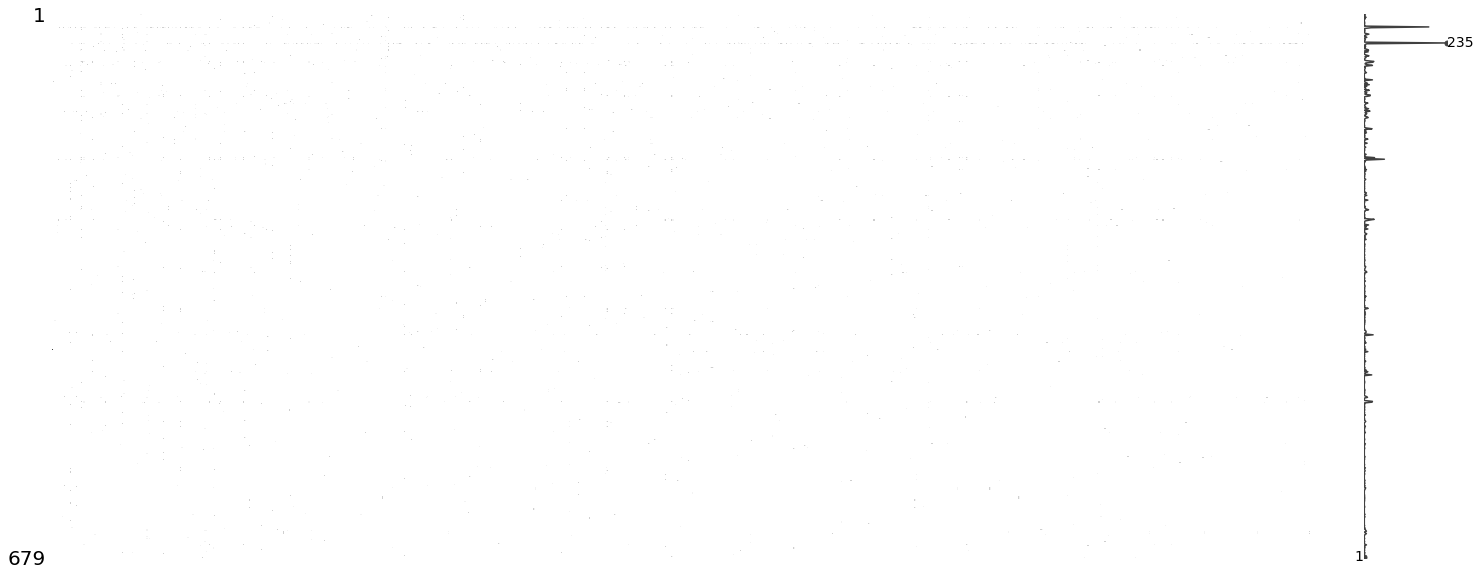

In [215]:
pivot_df_pfam_a = pd.pivot_table(pfam_cid, values='value', index='CID', columns='pfam_id', aggfunc='sum')

msno.matrix(pivot_df_pfam_a)

In [216]:
pivot_df_pfam_a.shape

(679, 1040)

<AxesSubplot:>

<Figure size 1800x720 with 2 Axes>

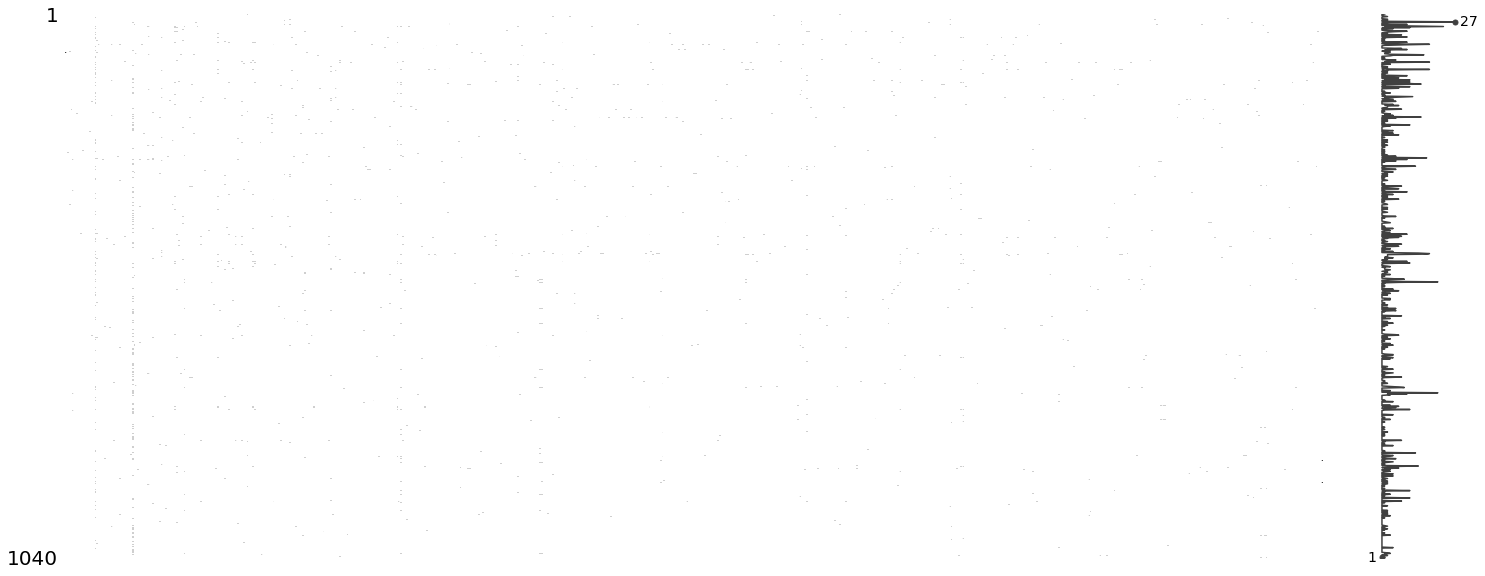

In [217]:
pivot_df_pfam_b = pd.pivot_table(pfam_cid, values='value', index='pfam_id', columns='CID', aggfunc='sum')

msno.matrix(pivot_df_pfam_b)

<AxesSubplot:>

<Figure size 432x288 with 1 Axes>

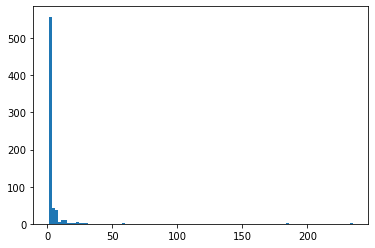

In [218]:
pfam_cid.groupby('CID').sum()['value'].hist(grid=False, bins=100)

<AxesSubplot:>

<Figure size 432x288 with 1 Axes>

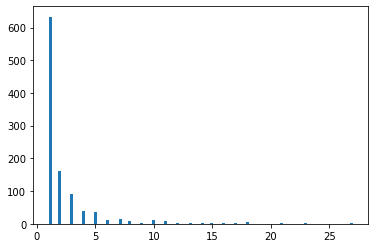

In [219]:
pfam_cid.groupby('pfam_id').sum()['value'].hist(grid=False, bins=100)

# Could we Help with Sparsity through Embedding?

In [11]:
proteins = input_df[['uniprot_ids','aa_sequence']].drop_duplicates()

In [12]:
def breakapart(word, groupsize=1, overlapsize=0): 
    brokeapart = [word[i:i+groupsize] for i in range(0, len(word), groupsize-overlapsize)]
    return [i for i in brokeapart if len(i) == groupsize]

In [13]:
sequences = [breakapart(i, groupsize=1, overlapsize=0) for i in proteins['aa_sequence'].values]

proteins['sequence'] = sequences
proteins['id'] = list(range(len(proteins)))

In [14]:
sgt = SGT(kappa=10, 
          flatten=True, 
          lengthsensitive=False,
          mode='multiprocessing')

In [15]:
#embedding = sgt.fit_transform(corpus=proteins)

In [16]:
#embedding.to_csv('protein_seq_embeddings_kappa_5_wordsize_2.tsv', sep='\t')
embedding = pd.read_csv('protein_seq_embeddings_kappa_10.tsv', sep='\t')

In [17]:
embedding.shape

(4147, 486)

In [18]:
embedding

,Unnamed: 0,id,"('A', 'A')","('A', 'C')","('A', 'D')","('A', 'E')","('A', 'F')","('A', 'G')","('A', 'H')","('A', 'I')",...,"('Y', 'P')","('Y', 'Q')","('Y', 'R')","('Y', 'S')","('Y', 'T')","('Y', 'U')","('Y', 'V')","('Y', 'W')","('Y', 'X')","('Y', 'Y')"
0,0,0.0,0.116337,1.079506e-12,0.110269,0.115835,0.118936,0.097160,0.126582,0.122185,...,0.042017,0.006897,0.114174,0.046951,0.143431,0.0,0.116912,2.160408e-02,0.0,0.000136
1,1,1.0,0.121866,1.320430e-01,0.115365,0.102013,0.109045,0.117633,0.118769,0.049465,...,0.115560,0.023939,0.114949,0.002433,0.001037,0.0,0.121982,1.604103e-04,0.0,0.149244
2,2,2.0,0.119937,1.606340e-01,0.104981,0.038114,0.123844,0.130977,0.048341,0.092005,...,0.039194,0.128410,0.119624,0.127969,0.145669,0.0,0.108411,1.063544e-03,0.0,0.132564
3,3,3.0,0.123501,1.547187e-01,0.102936,0.094278,0.124711,0.129466,0.131426,0.084583,...,0.106164,0.122031,0.109599,0.130582,0.112469,0.0,0.124974,1.079666e-03,0.0,0.123883
4,4,4.0,0.119776,9.546132e-03,0.105075,0.104012,0.103915,0.120726,0.097481,0.114973,...,0.120159,0.144603,0.112256,0.040646,0.121096,0.0,0.128696,3.715871e-04,0.0,0.124042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4142,5113,4142.0,0.130680,5.666032e-03,0.091461,0.115367,0.090024,0.105167,0.091588,0.117278,...,0.106393,0.117107,0.106636,0.100503,0.120420,0.0,0.114689,1.053820e-03,0.0,0.042677
4143,5114,4143.0,0.127414,0.000000e+00,0.091317,0.106515,0.111599,0.114178,0.110831,0.116303,...,0.113042,0.104021,0.103845,0.116184,0.116839,0.0,0.125910,1.187781e-01,0.0,0.006775
4144,5115,4144.0,0.122337,1.444123e-01,0.092129,0.103560,0.119177,0.034874,0.133352,0.016723,...,0.101401,0.014711,0.105478,0.123959,0.100520,0.0,0.108749,1.188617e-01,0.0,0.005861
4145,5116,4145.0,0.115247,1.927440e-02,0.110672,0.117500,0.106172,0.125105,0.116727,0.117764,...,0.123670,0.002131,0.050834,0.102389,0.122764,0.0,0.040515,1.183668e-01,0.0,0.016323


In [19]:
pca = PCA(n_components=2)
pca.fit(embedding)

X = pca.transform(embedding)
print(pca.explained_variance_ratio_)

[9.99758092e-01 2.41543617e-04]


In [20]:
X = pd.DataFrame(X)

<matplotlib.collections.PathCollection object at 0x7f8dd7478640>

<Figure size 1512x720 with 1 Axes>

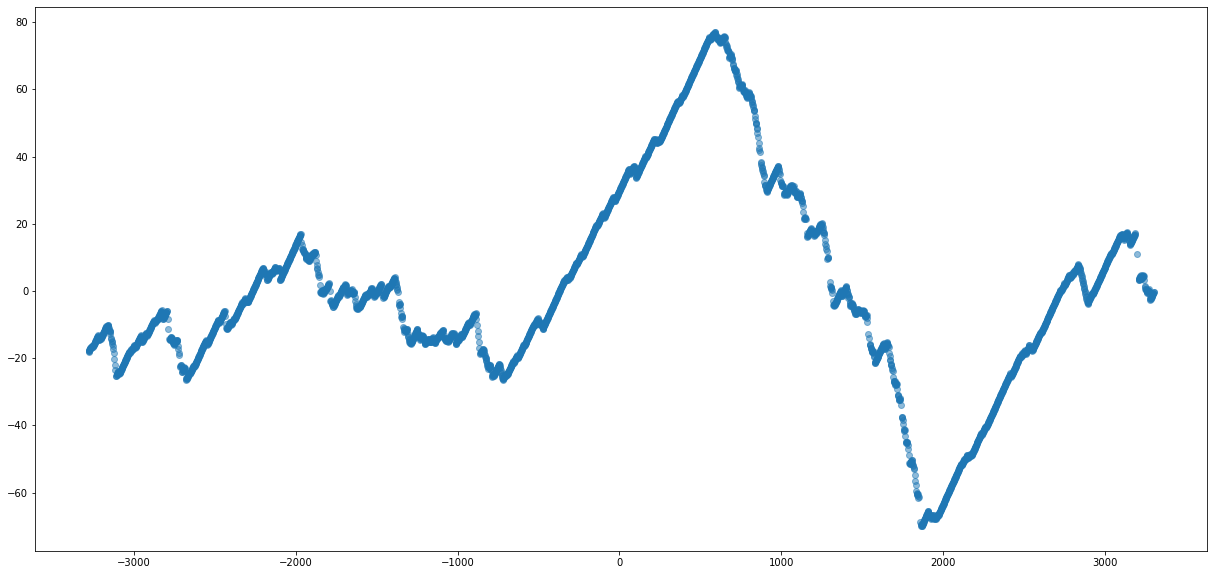

In [21]:
fig = plt.figure(figsize=(21, 10))
plt.scatter(X[0], X[1], alpha=0.5)

# This would imply that this embedding explains 99% of the variance, does that even seem reasonable?

Likely not. As we can see above, we have a lot of the protein variation explained by this but we don't really have any clustering sort of structure with this embedding. This actually makes sense though, since these "words" are really just amino acids. So, yes each protein will be different in terms of its amino acids BUT that sort of different probably isn't helpful to us.

We can try different embeddings though, how about ElMo and seqvec. This is a bit complex to install so we'll just run it in a Docker container:

```
docker pull continuumio/anaconda3

docker run -i -t -p 8888:8888 continuumio/anaconda3 /bin/bash -c "\
    conda install jupyter -y --quiet && \
    mkdir -p /opt/notebooks && \
    jupyter notebook \
    --notebook-dir=/opt/notebooks --ip='*' --port=8888 \
    --no-browser --allow-root"
   
pip insall seqvec
```

Then we'll make a multi-fasta file of the uniprot sequences and use the trained SeqVec model to create 1024-dimensional embeddings.

In [134]:
# df = pd.DataFrame(X)

# kmeans = KMeans(n_clusters=3, max_iter =300)
# kmeans.fit(df)

# labels = kmeans.predict(df)
# centroids = kmeans.cluster_centers_

In [42]:
seqRecords = []

for idx,row in input_df.iterrows():
    seqRecords.append(SeqRecord(seq=Seq(row['aa_sequence']), description='', id=row['uniprot_ids']))

In [56]:
# handle = open("uniprot_records.fasta", "w")
# writer = FastaWriter(handle)
# writer.write_file(seqRecords[:1])
# handle.close()

In [41]:
#!wget http://maintenance.dallago.us/public/embeddings/embedding_models/seqvec/weights.hdf5 -P seqvec_items
#!wget http://maintenance.dallago.us/public/embeddings/embedding_models/seqvec/options.json -P seqvec_items

In [22]:
all_seqvec_embeddings = pd.read_csv('all_embeddings.tsv', sep='\t').drop('Unnamed: 0', axis=1)

In [23]:
all_seqvec_embeddings

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,uniprot_ids
0,0.061668,-0.011562,-0.155775,0.045183,-0.053769,-0.136015,0.168084,0.060509,-0.029614,-0.084653,...,-0.013427,-0.040747,-0.025586,-0.070947,0.034767,0.082935,-0.056416,-0.198315,0.092121,P20582
1,0.061947,-0.011454,-0.155642,0.045413,-0.053923,-0.135743,0.167947,0.060689,-0.029285,-0.085000,...,-0.013513,-0.040610,-0.025526,-0.071241,0.034698,0.082479,-0.056647,-0.198183,0.092295,P20582
2,-0.040772,-0.033312,-0.070431,-0.064614,0.026569,-0.047782,0.038973,-0.053795,-0.011555,0.019463,...,0.032987,0.024324,-0.064921,0.026177,-0.045553,-0.030747,-0.062310,-0.027512,-0.060384,D8LJ35
3,-0.040772,-0.033312,-0.070431,-0.064614,0.026570,-0.047782,0.038973,-0.053795,-0.011555,0.019463,...,0.032987,0.024324,-0.064921,0.026176,-0.045553,-0.030746,-0.062310,-0.027512,-0.060385,Q9ZGI5
4,0.146428,-0.026196,-0.024167,0.051469,-0.024123,-0.146569,-0.014443,0.111686,0.038920,-0.074090,...,-0.055330,-0.052571,-0.114726,0.042616,-0.022270,0.063841,-0.067470,-0.206141,-0.013968,Q9ZGI5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,0.009684,0.066056,-0.093896,0.156312,-0.094560,-0.062767,0.218391,0.056684,0.006121,-0.198964,...,-0.195577,-0.249457,0.021755,-0.021353,-0.108717,0.010394,0.059653,-0.008078,-0.145264,P19096
4496,0.028320,-0.091284,-0.068231,0.016319,-0.011933,-0.089482,0.083082,0.012840,-0.078260,0.044283,...,0.000988,0.061820,-0.040709,-0.057202,-0.013779,0.024549,-0.058292,-0.116102,0.085832,P19096
4497,0.017661,-0.101572,-0.058822,-0.062824,0.091818,-0.101345,0.125366,-0.058744,-0.066405,-0.067241,...,0.010795,0.053901,-0.096938,-0.050820,-0.007899,0.024436,0.001863,-0.151836,0.017805,Q9VMG0
4498,0.017779,-0.100749,-0.058540,-0.062142,0.091819,-0.100963,0.124857,-0.058818,-0.065872,-0.067638,...,0.009614,0.054113,-0.096425,-0.050364,-0.007921,0.024246,0.001986,-0.151545,0.018060,Q9VMG0


In [24]:
pca = PCA(n_components=2)
pca.fit(embedding)


X = all_seqvec_embeddings.drop('uniprot_ids', axis=1).values

X = pca.transform(embedding)
print(np.sum(pca.explained_variance_ratio_))
X = pd.DataFrame(X)

0.9999996356501238


<matplotlib.collections.PathCollection object at 0x7f8dd71d1c40>

<Figure size 432x288 with 1 Axes>

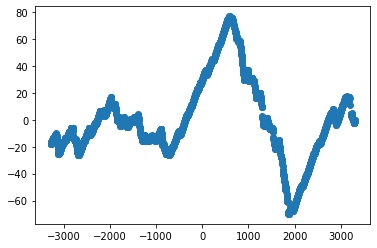

In [25]:
plt.scatter(X[0], X[1])

In [26]:
pfam_cid

,pfam_id,CID,value
0,PF14310,9918692,1
1,PF00933,9918692,1
2,PF01915,9918692,1
14,PF00201,9918692,1
15,PF00201,9852086,1
...,...,...,...
7302,PF07691,127656,1
7303,PF00232,468284,1
7304,PF00232,10925943,1
7308,PF00232,5316752,1


# Let's Explore a Baseline Using PFAMs and CIDs

## Create Dropout DatFrame

In [27]:
pfam_cid_chem = pfam_cid.merge(input_df[['CID','MorganFingerprint','CanonicalSMILES']].drop_duplicates(), on='CID', how='inner')

In [28]:
# Let's drop out 10%
dropouts_ground_truth = pfam_cid_chem.sample(frac=0.1)

In [29]:
keep_pfam_cid = pfam_cid_chem.append(dropouts_ground_truth).drop_duplicates(keep=False)

<ipython-input-29-12f82f67826f>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  keep_pfam_cid = pfam_cid_chem.append(dropouts_ground_truth).drop_duplicates(keep=False)


In [30]:
dropouts = dropouts_ground_truth.copy()
dropouts['pfam_id'] = np.nan

In [92]:
morgan_np = []

for fp in pfam_cid_chem['MorganFingerprint'].values:
    morgan_np.append( np.array([float(i) for i in fp.replace('\n','').strip('[').strip(']').split(' ')]) )

pfam_cid_chem['MorganFingerprint_np'] = morgan_np

morgan_matrix = np.matrix([list(i) for i in pfam_cid_chem['MorganFingerprint_np'].values])

## Create Similarity Matrix (Pairwise) Using Cosine Sim and Morgan Fingerprints

In [93]:
sim = cosine_similarity(X=morgan_matrix, Y=None, dense_output=True)

<Figure size 864x864 with 2 Axes>

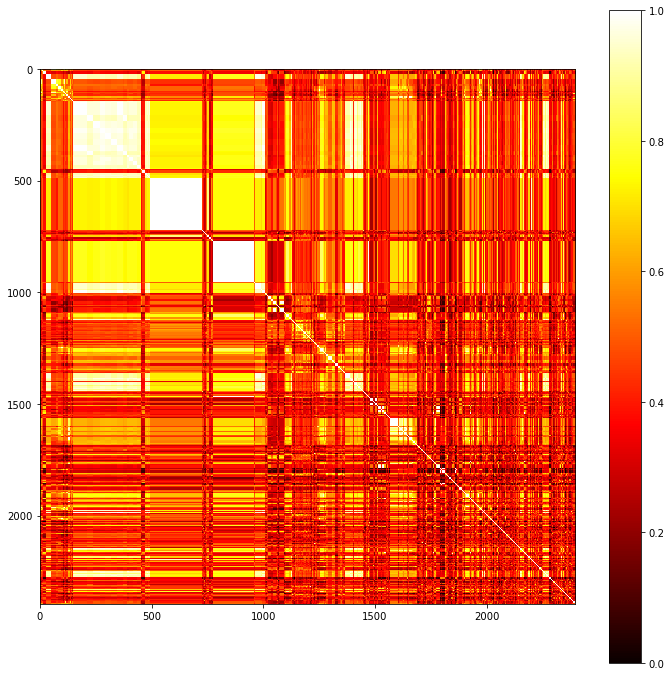

In [108]:
plt.figure(figsize=(12,12))
plt.imshow(sim, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

## Score how useful this matrix is by using it to find the Pfams for dropouts

In [115]:
test_set = dropouts.reset_index().rename(columns={'index':'matrix_lookup'})

In [218]:
###
# Top 1
###

# predicted_partners = []

# for test_cid in test_set['CID'].values:
#     #Let's be sure that, when querying a compound, we remove that exact compound from the similarity matrix otherwise we're just looking for alternative annotations.
#     non_self = np.delete(sim[entity['matrix_lookup']], pfam_cid_chem[pfam_cid_chem['CID']==test_cid].index.values, axis=0)
#     pred_pfam = pfam_cid_chem.iloc[np.argmax(non_self)]['pfam_id']
#     predicted_partners.append(pred_pfam)
    
# dropouts_ground_truth['predicted_partner'] = predicted_partners


###
# Top K
###
def run_top_k(df, test_set, sim, K):
    
    predicted_partners = []

    for test_cid in test_set['CID'].values:
        #Let's be sure that, when querying a compound, we remove that exact compound from the similarity matrix otherwise we're just looking for alternative annotations.
        non_self = np.delete(sim[entity['matrix_lookup']], pfam_cid_chem[pfam_cid_chem['CID']==test_cid].index.values, axis=0)
        topK_ind = np.argpartition(non_self, -K)[-K:]
        pred_pfam_topK = pfam_cid_chem.loc[topK_ind]['pfam_id'].values
        predicted_partners.append(",".join(pred_pfam_topK))

    df[f"predicted_partner_top{K}"] = predicted_partners
    

run_top_k(dropouts_ground_truth, test_set, sim, 1)
run_top_k(dropouts_ground_truth, test_set, sim, 5)
run_top_k(dropouts_ground_truth, test_set, sim, 10)

## Score the Results

In [227]:
dropouts_ground_truth.head(2)

,pfam_id,CID,value,MorganFingerprint,CanonicalSMILES,predicted_partner,predicted_partner_topK,predicted_partner_top5,predicted_partner_top1,predicted_partner_top10
320,PF16197,644066,1,[1 0 0 1 1 1 0 0 1 1 0 1 1 1 1 0 1 1 0 1 0 1 0...,CC(C)(COP(=O)(O)OP(=O)(O)OCC1C(C(C(O1)N2C=NC3=...,PF03061,"PF02797,PF00441,PF00755,PF00364,PF00198","PF02797,PF00441,PF00755,PF00364,PF00198",PF01039,"PF00975,PF08541,PF01852,PF02770,PF00441,PF0036..."
1683,PF12643,134820535,1,[0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0...,C1C(C(OC1N2C=C(C(=NC2=O)N)Cl)COP(=O)([O-])OP(=...,PF03061,"PF02797,PF00195,PF00583,PF00797,PF08659","PF02797,PF00195,PF00583,PF00797,PF08659",PF01039,"PF08545,PF01648,PF02797,PF00583,PF00797,PF0252..."


In [275]:
metrics = {}

def score_outcomes(ground_truth_df):
    scores = collections.defaultdict(str)
    
    for cid in ground_truth_df['CID'].values:
        scores[cid] = {}
        cid_rows = ground_truth_df[ground_truth_df['CID']==cid]
        truths = cid_rows['pfam_id'].values
        for K in [1,5,10]:
            predictions = cid_rows[f"predicted_partner_top{K}"].values
            pred_list = list(set(predictions[0].split(',')))
        
            pk = len([i for i in pred_list if i in truths])/K
            scores[cid][f"pk_{K}"]=pk
            
        scores[cid]['apk'] = np.mean([scores[cid][f"pk_{K}"] for K in [1,5,10]])
            
    return scores

In [283]:
mapk = np.mean([v['apk'] for k,v in score_outcomes(dropouts_ground_truth).items()])

In [284]:
mapk

0.005238095238095239